# Practicum 3: Model Development and Tuning

### Question 1 — The DS Problem (0 point)

In your own words, formulate the Data Science problem.


The main goal of this project is to figure out how different health factors and social conditions are connected to diabetes outcomes. We want to look at things like BMI, physical activity, mental health, and socioeconomic factors to see how they might influence whether someone has no diabetes, prediabetes, or diabetes. By understanding these patterns, we hope to come up with helpful insights that can make it easier to prevent or manage diabetes and improve healthcare decisions.

### Question 2 — Prepare the Data (5 pts)

Evaluate the dataset to determine if ALL variables are represented in their expected type. Convert variables to suitable data types for ML modeling. This means that you need to identify categorical data, discrete and continuous variables represent them accordingly.
Analyze the data to determine what preprocessing steps are needed to ensure that the following are handled: 1) missing values, 2) invalid values, 3) outliers. Perform the required data preparation steps and justify the approach that is taken to prepare the data for analysis.


In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error


In [2]:

# Data Cleaning
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
print(df.head())

# Checking variable types
print(df.dtypes)

# Dropping NaN and duplicate values
df = df.dropna(axis=0, how='any')
df = df.drop_duplicates()

# Describing data
print(df.describe())

# Continuous variables worth checking
cont = ['BMI', 'MentHlth', 'PhysHlth']

# Box plot for each column
for col in ['BMI', 'MentHlth', 'PhysHlth']:
    plt.figure()
    df.boxplot(column=col)
    plt.title(f'Box Plot for {col}')
    plt.show()

# Find outliers
def drop_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_df = df[(df[column] > upper_bound) |  (df[column] < lower_bound)]
    return filtered_df

# Drop outliers
filtered_df = drop_outliers(df, 'MentHlth')
filtered_df = drop_outliers(df, 'PhysHlth')
filtered_df = drop_outliers(df, 'BMI')

print(f"OG dataset shape: {df.shape}")
print(f"Filtered dataset shape: {filtered_df.shape}")

FileNotFoundError: [Errno 2] No such file or directory: 'diabetes_012_health_indicators_BRFSS2015.csv'

To prepare the dataset, we first loaded it and examined the variable types. Categorical variables, such as HighBP, HighChol, and Diabetes_012 (the target variable), represent distinct groups or conditions and are encoded as integers. Continuous variables, including BMI, MentHlth, and PhysHlth, are stored as floats since they represent measurements on a continuous scale. Discrete variables, such as Age, Education, and Income, are represented as integers and take on whole-number values within a finite range. Missing values were removed using dropna(), and duplicate rows were eliminated using drop_duplicates() to ensure data integrity. The dataset was summarized using descriptive statistics to identify key patterns and anomalies. Continuous variables (BMI, MentHlth, and PhysHlth) were visualized with box plots to detect outliers. Outliers were identified using the Interquartile Range (IQR) method, with values outside 1.5 times the IQR flagged for removal. This process involved calculating the lower and upper bounds for each variable and filtering out entries that fell outside these thresholds. The final dataset, now free of missing values, duplicates, and outliers, was ready for analysis, ensuring clean and reliable data for further exploration and modeling.

### Question 3 — (20 points)

Perform exploratory data analysis. Ensure that you analyze the relationships between the various features and social determinants of health in the dataset, and the diabetic outcomes. Create visualizations to demonstrate your findings and explain the results.


In [ ]:
# Exploratory data analysis

# Correlation map
plt.figure(figsize=(14,8))
correlation_matrix = filtered_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Heatmap", size=30)
plt.show()
print("The correlation heatmap reveals significant relationships between various features in the dataset. Diabetes outcomes exhibit moderate positive correlations with BMI, age, and general health, suggesting that higher BMI, older age, and poorer general health are strongly associated with diabetes. Physical activity is negatively correlated with diabetes outcomes, indicating that increased physical activity is linked to a reduced risk of diabetes. Socioeconomic factors like income and education show weaker negative correlations with diabetes outcomes, hinting at being potentially influence.")

# Diabetes Diagnoses distribution
sns.countplot(x="Diabetes_012", data=filtered_df)
plt.title("Distribution of Diabetes Results", size=20)
plt.xlabel("Diabetes Diagnoses (0 = No Diabetes, 1 = Prediabetes, 2 = Diabetes)")
plt.ylabel("Count")
plt.show()
print("The distribution of diabetes results highlights an imbalanced dataset, with the majority of individuals having no diabetes (0), followed by fewer cases of prediabetes (1) and diabetes (2). This makes sense since the majority of the population, thankfully, does not have diabetes. This skewed distribution reflects the general population trend but also underscores the need for balanced sampling in predictive modeling.")

# BMI vs. Diabetes Diagnoses
sns.boxplot(x="Diabetes_012", y="BMI", data=filtered_df)
plt.title("BMI vs. Diabetes Diagnoses", size=20)
plt.xlabel("Diabetes Diagnoses")
plt.ylabel("BMI")
plt.show()
print("The BMI vs. diabetes diagnoses box plot indicates that median BMI increases as diabetes outcomes progress from 0 (no diabetes) to 2 (diabetes). This suggests that higher BMI is a significant risk factor for diabetes. Additionally, the wider range of BMI values among individuals with diabetes highlights the variability in how BMI relates to the condition.")

# Income vs. Diabetes Diagnoses
sns.boxplot(x="Diabetes_012", y="Income", data=filtered_df)
plt.title("Income vs. Diabetes Diagnoses", size=20)
plt.xlabel("Diabetes Diagnoses")
plt.ylabel("Income")
plt.show()
print("The income vs. diabetes diagnoses box plot shows that people with diabetes (2) tend to have lower median incomes compared to those without diabetes (0). The plot also shows how the range of income levels narrows as diabetes outcomes progress, implying that lower income may be linked to a higher risk of diabetes (potentially due to reduced access to healthcare or healthy lifestyle choices).")

# Age vs. Diabetes Diagnoses
sns.boxplot(x="Diabetes_012", y="Age", data=filtered_df)
plt.title("Age vs. Diabetes Diagnoses", size=20)
plt.xlabel("Diabetes Diagnoses")
plt.ylabel("Age")
plt.show()
print("The age vs. diabetes diagnoses box plot visualizes how the median age increases as diabetes diagnoses progress from 0 (no diabetes) to 2 (diabetes), indicating that older individuals are more likely to develop diabetes. Notably, there are a few outliers in the younger age range for those diagnosed with diabetes, emphasizing that while diabetes is more common in older populations, it can still affect younger individuals. This plot highlights the strong influence of age on diabetes risk.")

# General Health vs. Diabetes Diagnoses
sns.boxplot(x="Diabetes_012", y="GenHlth", data=filtered_df)
plt.title("General Health vs. Diabetes Diagnoses", size=20)
plt.xlabel("Diabetes Diagnoses")
plt.ylabel("General Health (1-5 in order of healthiest to least healthy)")
plt.show()
print("Lastly, the general health vs. diabetes diagnoses box plot illustrates that self-reported general health worsens with the progression of diabetes diagnoses. Those with diabetes (2) report the poorest health, with the highest median scores, reflecting a clear decline in overall health as diabetes advances. This reinforces the strong association between diabetes and deteriorating physical health.")




### Question 4a — (20 points)

Perform significance tests to determine if the patterns that are detected above are statistically significant. Ensure that you discuss at least three patterns and the respective p-values.
Select the features that will be used in the ML models (i.e. your selected features should be based on analytical reasoning that demonstrates their utility for ML modeling. Do not arbitrarily select features.
Note: if you are using correlations, ensure that this is only performed using continuous variables.


In [ ]:

# Function to test significance and print results
def test_significance(feature_name, anova_result):
    print(f"ANOVA Test for {feature_name} vs. Diabetes Diagnosis: F-statistic={anova_result.statistic:.2f}, p-value={anova_result.pvalue:.4f}")
    if anova_result.pvalue < 0.05:
        print(f"Result: {feature_name} shows a statistically significant difference across diabetes categories (p < 0.05).\n")
    else:
        print(f"Result: {feature_name} does NOT show a statistically significant difference across diabetes categories (p >= 0.05).\n")

# ANOVA for BMI vs. Diabetes Diagnosis
anova_bmi = f_oneway(
    filtered_df[filtered_df['Diabetes_012'] == 0]['BMI'],
    filtered_df[filtered_df['Diabetes_012'] == 1]['BMI'],
    filtered_df[filtered_df['Diabetes_012'] == 2]['BMI']
)
test_significance("BMI", anova_bmi)

# ANOVA for Income vs. Diabetes Diagnosis
anova_income = f_oneway(
    filtered_df[filtered_df['Diabetes_012'] == 0]['Income'],
    filtered_df[filtered_df['Diabetes_012'] == 1]['Income'],
    filtered_df[filtered_df['Diabetes_012'] == 2]['Income']
)
test_significance("Income", anova_income)

# ANOVA for Age vs. Diabetes Diagnosis
anova_age = f_oneway(
    filtered_df[filtered_df['Diabetes_012'] == 0]['Age'],
    filtered_df[filtered_df['Diabetes_012'] == 1]['Age'],
    filtered_df[filtered_df['Diabetes_012'] == 2]['Age']
)
test_significance("Age", anova_age)


I perform 3 ANOVA tests on the correlation of continous variables against a categorical. Here, I test if BMI, Income level, and age show a statistically significant difference between the categories of Diabetic(nondiabetic, prediabetic, and diabetic).

The ANOVA test for all three features returned a p-value that rounded down to 0.0000 - meaning there is effectively 0% probability that the differences in BMI, Age, and Income across the categories of diabetic are caused by random chance. We are able to reject the null hypothesis that there is no correlation between:

BMI and Diabetic Status
Income and Diabetic Status
Age and Diabetic Status

And declare each relationship statistically significant.

Because of this correlation, it is useful to interrogate whether these features would strengthen an ML classification model that would classify a person into nondiabetic, prediabetic, and diabetic. BMI would likely be a strong predictive feature, as BMI is often indicative of high body fat percentage -- which has been established as a a risk factor for type 2 diabetes(See 1). Income is predictive of many other diseases and causes of mortality, which indicates some processes by which lower income people see worsened health outcomes. Frequent and adequate medical visits are not distributed equally across income(See 2). Thus, these populations may see worsened general medical outcomes. This too could be an important consideration when classifying a person into a diabetic status. Lastly, age is a strong predictor of diabetes, as studies show that a body's cells become less sensitive to insulin as they age(see 3), leading to the symptoms of diabetes. With this link established, age too could be an important consideration in this predictive model.

1: https://pmc.ncbi.nlm.nih.gov/articles/PMC6915175/

2: https://pmc.ncbi.nlm.nih.gov/articles/PMC3312363/

3: https://pmc.ncbi.nlm.nih.gov/articles/PMC5509969/

### [Optional] Question 4b — (10 points)
This is an optional challenge question. Its purpose is to identify new features that can be included in the ML modeling below.

Perform ONE of the following
(1) Feature engineering: Machine learning models can benefit greatly from feature engineering. Create a new feature that can be included in the model and perform significance testing to determine if it's statistically significant. Explain the results and justify if the feature will be included in the ML model. If you decide that you will not include the new feature in the ML model, explain the reasons.
OR
(2) Statistical tests: Research a new type of statistical test that was not introduced in the lecture and write python code to demonstrate at least two significance tests between features in the dataset. Explain the results and justify if the feature will be included in the ML model. If you decide that you will not include the analyzed feature(s) in the ML model, explain the reasons. Note: you are welcome to use libraries to perform the tests.

In [ ]:
# Selecting the continuous variables to apply PCA
cont_cols = ['GenHlth', 'MentHlth', 'PhysHlth']

# Standardize the data (important for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_df[cont_cols])

# Apply PCA to the scaled data
pca = PCA(n_components=1)  # We are interested in only the first principal component
principal_component = pca.fit_transform(scaled_data)

# Calculate the percentage of variance captured by the first principal component
explained_variance = pca.explained_variance_ratio_[0] * 100  # Multiply by 100 to get percentage

# Print the percentage of variance captured
print(f"Percentage of variance captured by PCA_1: {explained_variance:.2f}%")

# Add the first principal component to the dataframe
filtered_df['PCA_1'] = principal_component

# Perform ANOVA test to check if PCA_1 is significantly different across Diabetes_012 categories
anova_result = f_oneway(
    filtered_df[filtered_df['Diabetes_012'] == 0]['PCA_1'],
    filtered_df[filtered_df['Diabetes_012'] == 1]['PCA_1'],
    filtered_df[filtered_df['Diabetes_012'] == 2]['PCA_1']
)

# Print the ANOVA results
print(f"ANOVA Test for PCA_1 vs. Diabetes Diagnosis: F-statistic={anova_result.statistic:.2f}, p-value={anova_result.pvalue:.4f}")

# Interpret the results
if anova_result.pvalue < 0.05:
    print("The first principal component (PCA_1) is statistically significant (p < 0.05). It will be included in the ML model.\n")
else:
    print("The first principal component (PCA_1) is NOT statistically significant (p >= 0.05). It will NOT be included in the ML model.\n")

In [ ]:
# Set up the plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Diabetes_012', y='PCA_1', data=filtered_df, palette='Set2')

# Add title and labels
plt.title(f'Distribution of PCA_1 Across Diabetes Categories\n(Explained Variance: {explained_variance:.2f}%)', fontsize=14)
plt.xlabel('Diabetes Diagnosis (0: No Diabetes, 1: Pre-Diabetes, 2: Diabetes)', fontsize=12)
plt.ylabel('First Principal Component (PCA_1)', fontsize=12)

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In order to identify another feature for the machine learning classification model, I wanted to use a dimensionality reduction technique to reduce the effects of the curse of dimensionality. Thus, instead of incorporating the General Health, Mental Health, and Physical Health columns independently(as they exhibit multicollinearity, see correlation heatmap), we apply principal component analysis to reduce them to one column, which represents 62% of the variation seen in all three. Thus, we capture the more general aspects of health that these variables exibit. When performing the ANOVA test, the f-statistic of 240.23 - which translates to a p-value that rounds to 0 - indicates that there is effectively no chance that the principal component created from the three health columns has no correlation with a patient's level of diabetes. This means that it is likely a useful predictive factor for our classification model. The visualization above shows the differences in distributions of the Principal Component Feature across the categories of diabetic using a box plot.

### Question 5 — (5 points)

Partition the data into train/test sets. After which, perform the following:
encode any categorical data. Ensure that categorical variables are represented correctly.
normalize numeric data.
Tip: Ensure that you use sklearn to normalize and/or encode the training data, after which transform the test set (there is an example in the lecture).


In [ ]:
# Features and target
features = ['BMI', 'Income', 'Age', 'PCA_1']
target = 'Diabetes_012'

# Create a train/test split (80% train, 20% test)
X = filtered_df[features]
y = filtered_df[target]

# Split the data into training and testing sets (random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the numeric data using StandardScaler (BMI, Income, Age, PCA_1)
scaler = StandardScaler()

# Normalize the numeric features in the training data, and then transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the results of the scaling
print("Training set after scaling:")
print(pd.DataFrame(X_train_scaled, columns=features).head())

print("\nTesting set after scaling:")
print(pd.DataFrame(X_test_scaled, columns=features).head())

In [ ]:
# Create a plot to show the distribution before and after scaling for each feature
fig, axes = plt.subplots(2, len(features), figsize=(16, 8))

# Plot original data
for i, feature in enumerate(features):
    sns.histplot(X_train[feature], ax=axes[0, i], kde=True, color='blue', bins=20)
    axes[0, i].set_title(f'{feature} - Original')

    # Set x-axis limits based on original data
    axes[0, i].set_xlim(X_train[feature].min(), X_train[feature].max())

# Plot scaled data
for i, feature in enumerate(features):
    sns.histplot(X_train_scaled[:, i], ax=axes[1, i], kde=True, color='green', bins=20)
    axes[1, i].set_title(f'{feature} - Scaled')

    # Set x-axis limits for scaled data
    axes[1, i].set_xlim(-5, 5)  # Lock the x-axis scale for the normalized data

# Labeling
plt.suptitle('Feature Distribution Before and After Z-Score Normalization', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust to make space for the suptitle
plt.show()


Here, I z-score normalize the X variables to set the mean to 0 and the standard deviation to 1. Then, I apply an 80/20 train test split.

### Question 6 — (30 points)

Build the ML model that predicts the target variable based on the selected features. Ensure that you:
Demonstrate the training, evaluation and tuning for at least three algorithms that can handle non linear data and multiple input features/variables. NOTE: you can only select one tree-based algorithm and you must select multiple input features for the ML modeling.
Use GridSearchCV to tune at least two hyperparameters for each algorithm.
Note: do not change the input features in your experiments.


## SVM

In [ ]:
#initialize the classifier
svm = SVC() #the default kernel is rbf
svm.fit(X_train_scaled, y_train) #fit the data

#predict the labels for the test set
y_pred   = svm.predict(X_test_scaled)

#evaluate the prediction accuracy
print('The accuracy of the model is: {}'.format(round(svm.score(X_test_scaled, y_test), 2)))

#get hyperparameters
print("C:", svm.C)
print("Gamma:", svm.gamma)
print("Kernel:", svm.kernel)

#get the classification report
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred, target_names = target_names))

In [ ]:
#setup the parameter grid to try different values of C, gamma, and kernel.
params = {"C": [0.1, 1, 10, 100],
          "gamma": [0.01, 0.1, 1, 'scale'],
         "kernel": ['rbf', 'linear']}

#initialize classifier
svm = SVC()

#initialize Grid Search with Cross Validation
svm_grid = GridSearchCV(estimator = svm, param_grid = params, cv=5, return_train_score=True)
svm_grid.fit(X_train_scaled, y_train)

print('Best parameters:', svm_grid.best_params_) #print the best parameters
print('Best score:', round(svm_grid.best_score_, 2))  #print the best score

In [ ]:
#display the cv results for the train and test set
cv_results = pd.DataFrame(svm_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

Here, the default 'scale' for gamma is equal to the inverse of the number of features (4) multiplied by the variance of the scaled X-train data (1).  It comes out to 0.25.

[Helpful link](https://scikit-learn.org/1.5/modules/generated/sklearn.svm.SVC.html)

## k-NN

In [ ]:
#initialize the classifier and set the number of neighbors
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_scaled, y_train)

#predict the labels for the test set
y_pred = knn.predict(X_test_scaled)

#evaluate the model using Mean Squared Error
mse = round(mean_squared_error(y_test, y_pred), 2)
print(f"Initial Model MSE (k = 5): {mse}")

#evaluate the prediction accuracy
print('The accuracy of the model is: {}'.format(round(knn.score(X_test_scaled, y_test), 2)))

#get the classification report
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred, target_names = target_names))

In [ ]:
#setup the parameter grid to try values of n_neighbors, weights, and metric
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

#initialize classifier
knn = KNeighborsClassifier()

#initialize Grid Search with Cross Validation
knn_grid = GridSearchCV(estimator = knn, param_grid = knn_params, cv=5, return_train_score=True)
knn_grid.fit(X_train_scaled, y_train)

print('Best parameters:', knn_grid.best_params_) #print the best parameters
print('Best score:', round(knn_grid.best_score_, 2))  #print the best score

In [ ]:
#display the cv results for the train and test set
cv_results = pd.DataFrame(knn_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

[Helpful link](https://www.datasklr.com/select-classification-methods/k-nearest-neighbors)

## Random Forest

In [3]:
#initialize the classifier
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_scaled, y_train)

#predict the labels for the test set
y_pred   = rf.predict(X_test_scaled)

#evaluate the model using mean squared error
mse = round(mean_squared_error(y_test, y_pred), 2)
print('The mse of the model is: {}'.format(mse))

#evaluate the prediction accuracy
print('The accuracy of the model is: {}'.format(round(rf.score(X_test_scaled, y_test), 2)))

#get the classification report
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred, target_names = target_names))

NameError: name 'X_train_scaled' is not defined

In [ ]:
#setup the parameter grid to try values of n_estimators, max_depth, and min_samples_split
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

#initialize classifier
rf = RandomForestClassifier(random_state = 42)

#initialize Grid Search with Cross Validation
rf_grid = GridSearchCV(estimator = rf, param_grid = rf_params, cv=5, return_train_score=True)
rf_grid.fit(X_train_scaled, y_train)

print('Best parameters:', rf_grid.best_params_) #print the best parameters
print('Best score:', round(rf_grid.best_score_, 2))  #print the best score

In [ ]:
#display the cv results for the train and test set
cv_results = pd.DataFrame(rf_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

[Helpful Link](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

### Question 7 — (15 points)

Analyze the evaluated models. For each algorithm, ensure that you:
Display: 1) the best model and 2) the best score that was obtained.
Evaluate the scores from GridSearchCV for the training set and the test set to diagnose any bias-variance problems. Comment on the quality of the model.
NOTE: seeing that you are analyzing healthcare data, ensure that you discuss what is the desired metric to evaluate the results based on the machine learning task e.g. accuracy, precision, recall, f1-score, MSE, R2, etc.

1) SVM

Best Model: {'C': 100, 'gamma': 0.1}
Best Score: 0.65 (cross-validation score)

The SVM model performed reasonably well with an accuracy of 66%, but its performance in detecting diabetic cases was subpar, with precision, recall and F1-score all equal to 0 for class 1, which is diabetic. The model's best parameters were C: 100, gamma : 0.1, but the difference between the training score(66.6%) and the test score 64.9% suggests low bias and potential underfitting. This indiccates that while the model is fitting the training data well, it struggles to generalize to unseen data, particularly with the minority class which is diabetic.

2) k-NN
Best Model: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Best Score: 0.63 (cross-validation score)

The k-NN model also showed issues with poor performance in predicting diabetics as seen through the lack of precision, recall, and F1-score for class 1. The model achieved an accuracy of 61%, but there was a gap between the training score (70.7%) and the test score (63.3%), indicating overfitting. The model memorizes the training data well but does not generalize to new data. Given the dataset imbalance, where non-diabetic cases are more prevalent, the k-NN model is biased toward the majority class, making it unsuitable for tasks where identifying diabetic individuals is essential.

3) Random Forest

Best Model: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 0.64 (cross-validation score)

The Random Forest model showed similar shortcomings with an accuracy of 61% with a 0 precision, recall, and F1-score for class 1. The model had a training score of 76.9% and a test score of 63.8%, indicating some level of overfitting. Although Random Forest is generally more robust to overfitting, its inability to detect diabetic cases here suggests the model's complexity may be leading it to focus on patterns that are not generalizable, particularly for the minority class.

**Overall, the model with the best performance was the Random Forest Model**


### Question 8 — (5 points)

Discuss the potential impacts of your solution. Who will benefit from (and/or who will be affected by) your solution and why.
Were there any concerns of bias in the ML modeling seeing that you were analyzing sensitive data? Create visualizations to share any analysis of bias in the training data and/or the predictions from the model. For example: you can compare and contrast the predictions for specific groups to demonstrate your findings. Provide recommendations on techniques to address any issues that were found.
Note: you are welcome to use libraries to perform the analysis.


The impacts of a machine learning (ML) solution can be significant for various stakeholders. Primary users directly benefit from improved decision-making and insights provided by the ML model, while organizations or stakeholders can make systems run more efficiently and with increased profitability. If designed equitably, the model can also address the challenges faced by marginalized groups. However, the model may also have unintended consequences for underrepresented groups if the training data is skewed, leading to biased predictions or system misbehavior that affects end users.

Bias concerns in ML modeling arise from several sources. Sampling bias occurs when certain groups are overrepresented or underrepresented in the training data, while labeling bias stems from errors or biases in human-generated labels. Algorithmic bias can emerge when the model performs differently across demographic groups, resulting in unfair outcomes for certain populations. These biases can amplify existing societal disparities or lead to negative impacts for underrepresented groups, highlighting the need for careful consideration in model design.

To address these biases, several recommendations can be implemented. Data balancing techniques can be used to increase the representation of underrepresented groups in the training dataset, ensuring a more equitable model. Fairness-aware algorithms, which use fairness constraints or regularization during training, can help minimize bias. Additionally, bias mitigation techniques can be applied to post-process predictions to ensure more equitable outcomes. Finally, regular audits of the model's performance across demographic groups are also important to identify and address any disparities that may be present.

Diabetes_012       0.0       1.0       2.0
Sex                                       
0.0           0.837421  0.020209  0.142370
1.0           0.813955  0.020064  0.165981


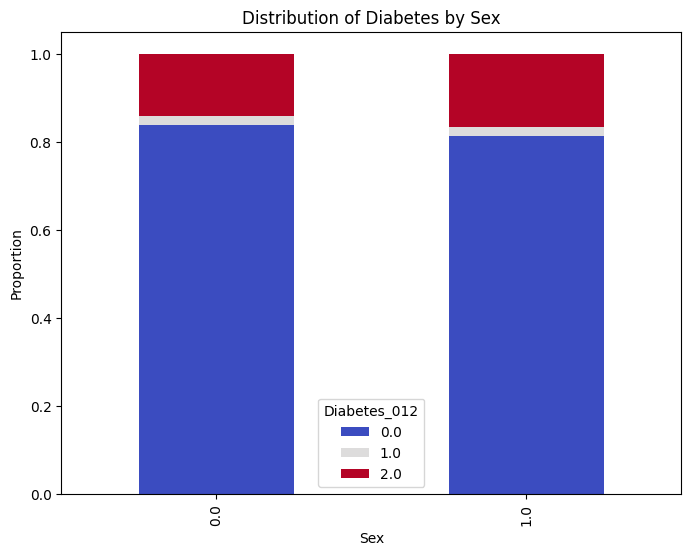

In [ ]:

sex_bias = df.groupby('Sex')['Diabetes_012'].value_counts(normalize=True).unstack()
print(sex_bias)

# Plot the bias in diabetes distribution by sex
sex_bias.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='coolwarm')
plt.title('Distribution of Diabetes by Sex')
plt.xlabel('Sex')
plt.ylabel('Proportion')
plt.show()


As we see in the graph above, both sexes have similar proportions of having diabetes, no diabetes, and pre-diabetes. If the proportions of males and females were significantly different in the dataset then this could be an indication of a potential bias. The dataset does not seeem to have bias based on sex

<Figure size 1000x600 with 0 Axes>

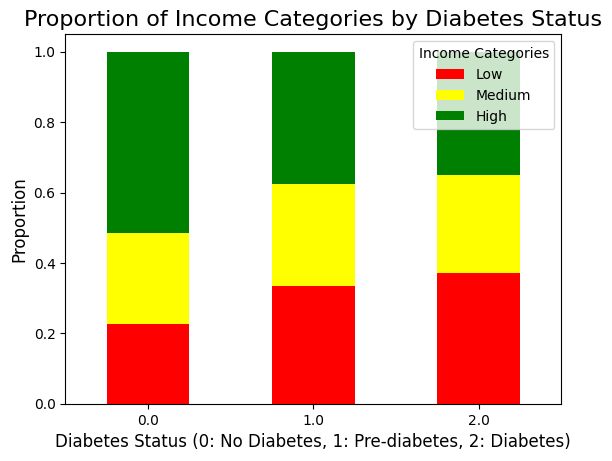

In [ ]:
bins = [0, 4, 6, 10]
labels = ['Low', 'Medium', 'High']
df['Income_Category'] = pd.cut(df['Income'], bins=bins, labels=labels)

income_by_diabetes = pd.crosstab(df['Diabetes_012'], df['Income_Category'], normalize='index')

plt.figure(figsize=(10, 6))
income_by_diabetes.plot(kind='bar', stacked=True, color=['red', 'yellow', 'green'])
plt.title('Proportion of Income Categories by Diabetes Status', fontsize=16)
plt.xlabel('Diabetes Status (0: No Diabetes, 1: Pre-diabetes, 2: Diabetes)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Income Categories', loc='upper right')
plt.show()

The analysis of income and diabetes status in the dataset shows a slight overrepresentation of high-income individuals in the "No Diabetes" group. However, the distribution of diabetes and pre-diabetes statuses across income categories appears fairly proportional. This suggests that, while there is some bias in the higher-income group, the dataset generally reflects a diverse range of income levels in relation to diabetes.

Proportions of healthcare by diabetes status:
AnyHealthcare       0.0       1.0
Diabetes_012                     
0.0            0.056378  0.943622
1.0            0.054871  0.945129
2.0            0.040516  0.959484


<Figure size 1000x600 with 0 Axes>

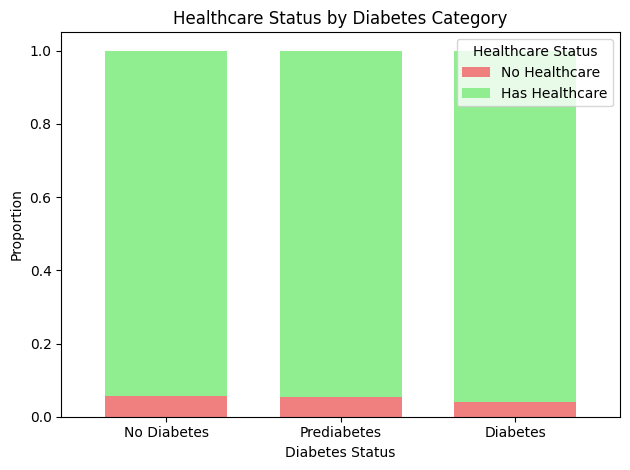

In [ ]:
healthcare_diabetes = pd.crosstab(df['Diabetes_012'], df['AnyHealthcare'], normalize='index')
print("Proportions of healthcare by diabetes status:")
print(healthcare_diabetes)

plt.figure(figsize=(10,6))
healthcare_diabetes.plot(kind='bar', stacked=True, color=['lightcoral', 'lightgreen'], width=0.7)
plt.title('Healthcare Status by Diabetes Category')
plt.xlabel('Diabetes Status')
plt.ylabel('Proportion')
plt.xticks([0, 1, 2], ['No Diabetes', 'Prediabetes', 'Diabetes'], rotation=0)
plt.legend(title='Healthcare Status', labels=['No Healthcare', 'Has Healthcare'])
plt.tight_layout()
plt.show()

The dataset shows a significant bias towards individuals with healthcare, as the majority of participants have healthcare coverage. This bias could skew the analysis of health conditions, such as diabetes, by underrepresenting the experiences of those without healthcare, who may face worse outcomes. To address this, resampling techniques, generating synthetic data, or incorporating additional variables can help balance the dataset and provide a more accurate, inclusive analysis of healthcare access and health outcomes.